In [14]:
# === Librerías ===
from google.cloud import bigquery
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


# === Cargar el dataset desde BigQuery ===
client = bigquery.Client()
query = """
SELECT * FROM `instant-bonbon-474722-g7.Resultados_Pruebas_Mayores.Analisis_Desercion_v2`
"""
df = client.query(query).to_dataframe()

df = df.drop(columns=['fecha_nacimiento'])

print(df.isnull().sum())  # <<< importante para verificar nulls


# ============
# Variables
# ============
target = "impacto_desercion"
X = df.drop(columns=[target])
y = df[target]

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()


# ================================
# PREPROCESAMIENTO CON IMPUTACIÓN
# ================================
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # imputar NaN en numéricas
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # imputar NaN en categóricas
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)


# ================
# Pipeline general
# ================
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])


# ================
# Train-test split
# ================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ==============================
# Búsqueda de hiperparámetros
# ==============================
param_grid = {
    'model__max_depth': [3, 5, 7, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__criterion': ['squared_error', 'friedman_mse']
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

print("\n=== Mejor combinación de hiperparámetros ===")
print(grid.best_params_)


# =======================
# VALIDACIÓN CRUZADA
# =======================
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

cv_results = cross_validate(
    grid.best_estimator_, X_train, y_train, cv=5, scoring=scoring
)

print("\n=== Resultados de Validación Cruzada ===")
print(f"R² promedio: {cv_results['test_r2'].mean():.4f}")
print(f"MSE promedio: {-cv_results['test_mse'].mean():.4f}")
print(f"RMSE promedio: {np.sqrt(-cv_results['test_mse'].mean()):.4f}")
print(f"MAE promedio: {-cv_results['test_mae'].mean():.4f}")


# =======================
# Evaluación final
# =======================
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== Evaluación Final Test ===")
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")


nombre                       0
arma                         0
liga                         0
puntos                      56
posicion                    56
categoria                    0
genero                       0
edad                        71
costo_licencia               0
costo_inscripcion            0
participaciones              0
ultimo_año_participacion     0
deserto                      0
desertor_confirmado          0
licencias_pagadas            0
inscripciones_totales        0
dinero_total_invertido       0
rendimiento_relativo        56
impacto_desercion            0
dtype: int64

=== Mejor combinación de hiperparámetros ===
{'model__criterion': 'squared_error', 'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}

=== Resultados de Validación Cruzada ===
R² promedio: 0.9968
MSE promedio: 1450259120.1637
RMSE promedio: 38082.2678
MAE promedio: 8408.6686

=== Evaluación Final Test ===
R²: 0.9900
MSE: 5685953009.7317
RMSE: 75405.2585
MAE: 15

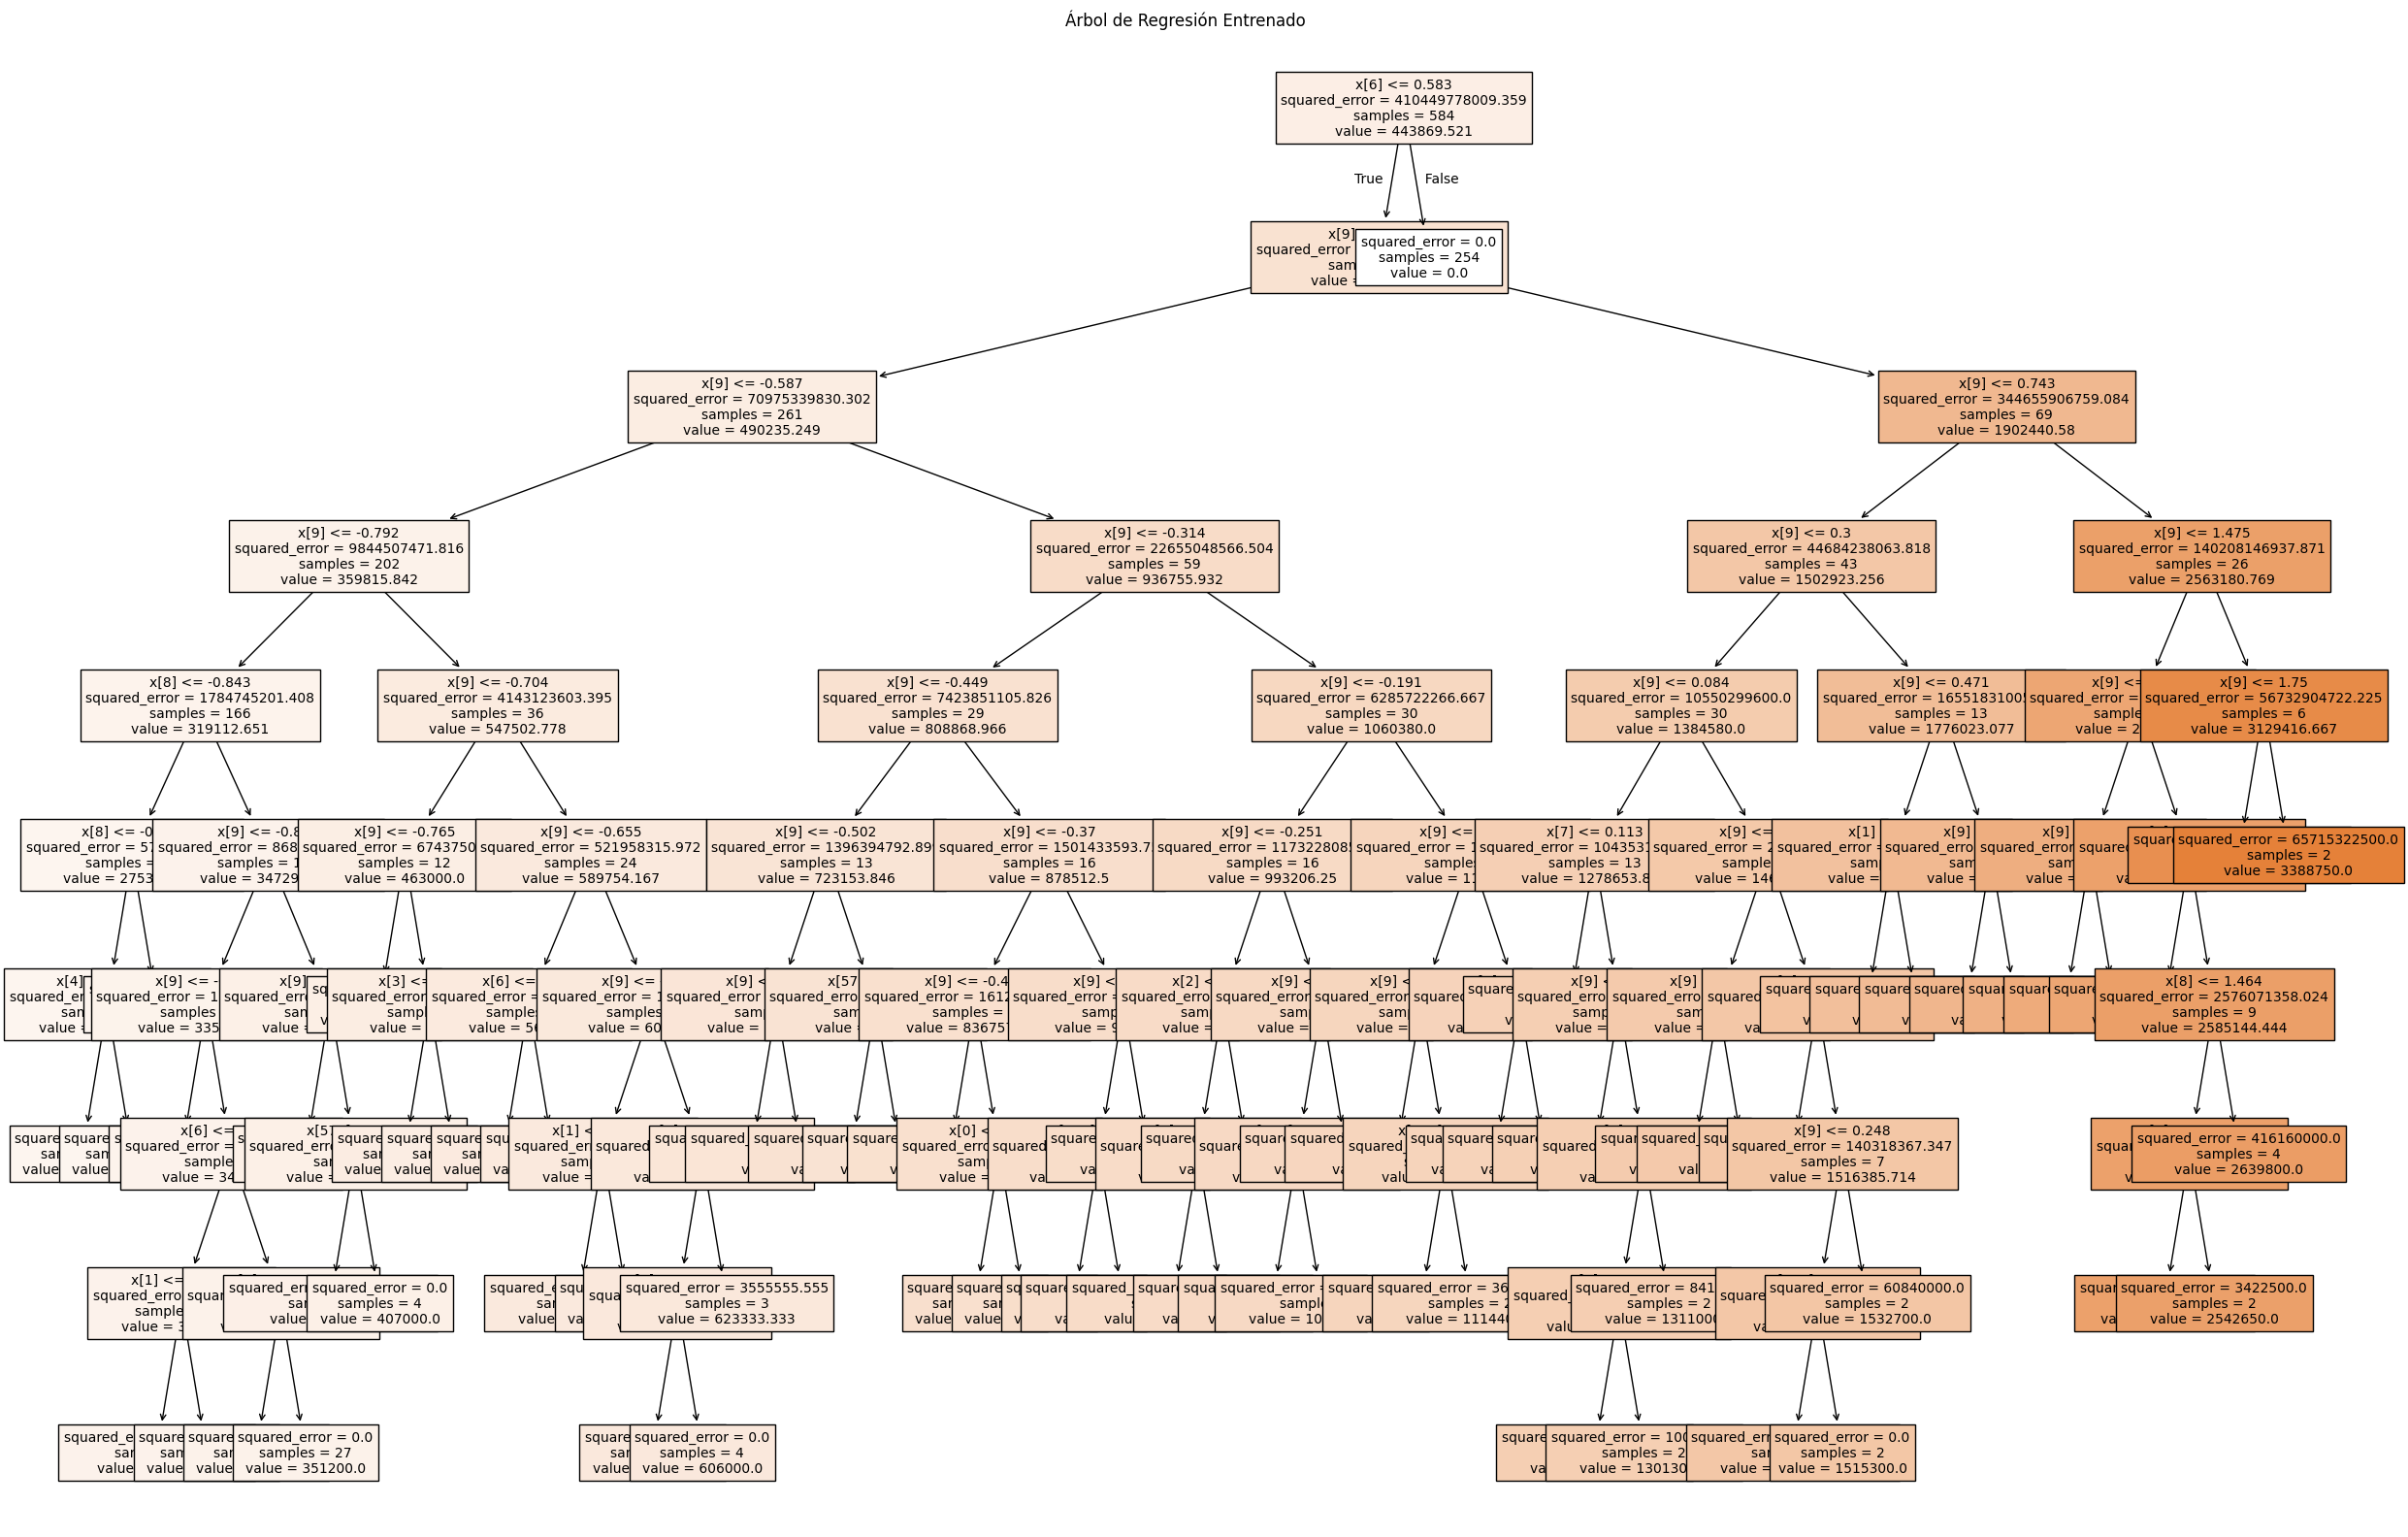

In [15]:
from sklearn.tree import plot_tree

# Extraer el árbol final del mejor modelo encontrado
best_tree = best_model.named_steps["model"]

plt.figure(figsize=(30, 20))
plot_tree(
    best_tree,
    filled=True,
    fontsize=10
)
plt.title("Árbol de Regresión Entrenado")
plt.show()
